In [2]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_5_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [3]:
df = df.loc[df['latest_docket_month'].isin(['2019-06',
                                            '2019-07',
                                            '2019-08',
                                            '2019-09',
                                            '2019-10',
                                            '2019-11',
                                            '2019-12',
                                            '2020-01',
                                            '2020-02',
                                            '2020-03']), :]

In [4]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [5]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_5_crimes_500m       2.911415e-182   
                                                 pre_treatment_change_in_group_5_crimes_500m       8.544583e-10   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                5.236459e-25   
                                                 job_density_2013                                  2.842258e-03   
                                                 med_hhinc2016                                     4.779290e-16   
                                                 poor_share2010                                    1.447627e-10   
                                                 popdensity2010                                    1.945958e-03   
Panel C: Case Initiation                         for_cause                                         9.799068e-01   
                                                 no_cause                                          2.719791e-01   
                                                 non_payment                                       4.680582e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          4.930764e-01   
                                                 hasAttyP                                          1.444664e-08   
                                                 isEntityD                                         2.124550e-03   
                                                 isEntityP                                         2.062287e-05   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_5_crimes_500m   0.941259  
                                                 pre_treatment_change_in_group_5_crimes_500m  0.896640  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.026586  
                                                 job_density_2013                             0.285288  
                                                 med_hhinc2016                                0.006887  
                                                 poor_share2010                               0.007088  
                                                 popdensity2010                               0.568300  
Panel C: Case Initiation                         for_cause                                    0.000297  
                                                 no_cause                                     0.160724  
                                                 non_payment                                  0.035557  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.000018  
                                                 hasAttyP                                     0.057909  
                                                 isEntityD                                    0.129970  
                                                 isEntityP                                    0.001203

In [6]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 5 Incidents, 2017                      34.939673   
        $\Delta$ Group 5 Incidents, 2017-2019              -3.722904   
Panel B Bachelor's degree, 2010                             0.324037   
        Job density, 2013                               17879.131663   
        Median household income, 2016                   47493.957055   
        Poverty rate, 2010                                  0.284488   
        Population density, 2010                        23692.018106   
Panel D Plaintiff has attorney                              0.879346   
        Defendant is entity                                 0.016360   
        Plaintiff is entity                                 0.824131   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 5 Incidents, 2017                                     0.076770   
        $\Delta$ Group 5 Incidents, 2017-2019                            -0.063226   
Panel B Bachelor's degree, 2010                                           0.024748   
        Job density, 2013                                              2380.874938   
        Median household income, 2016                                  3485.700604   
        Poverty rate, 2010                                               -0.020869   
        Population density, 2010                                        403.429752   
Panel D Plaintiff has attorney                                           -0.030332   
        Defendant is entity                                              -0.011059   
        Plaintiff is entity                                              -0.059740   

                                                                               
                                               \emph{p}    Weighted  \emph{p}  
Panel A Total Group 5 Incidents, 2017          0.941259   -0.556197  0.592130  
        $\Delta$ Group 5 Incidents, 2017-2019  0.896640    0.052027  0.915273  
Panel B Bachelor's degree, 2010                0.026586   -0.001998  0.831122  
        Job density, 2013                      0.285288   23.224223  0.991479  
        Median household income, 2016          0.006887 -311.515504  0.744385  
        Poverty rate, 2010                     0.007088   -0.007354  0.302947  
        Population density, 2010               0.568300 -330.954325  0.631977  
Panel D Plaintiff has attorney                 0.057909   -0.018240  0.249672  
        Defendant is entity                    0.129970   -0.001719  0.806638  
        Plaintiff is entity                    0.001203   -0.021211  0.192221

In [7]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [8]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 920/920 [00:18<00:00, 50.35it/s] 


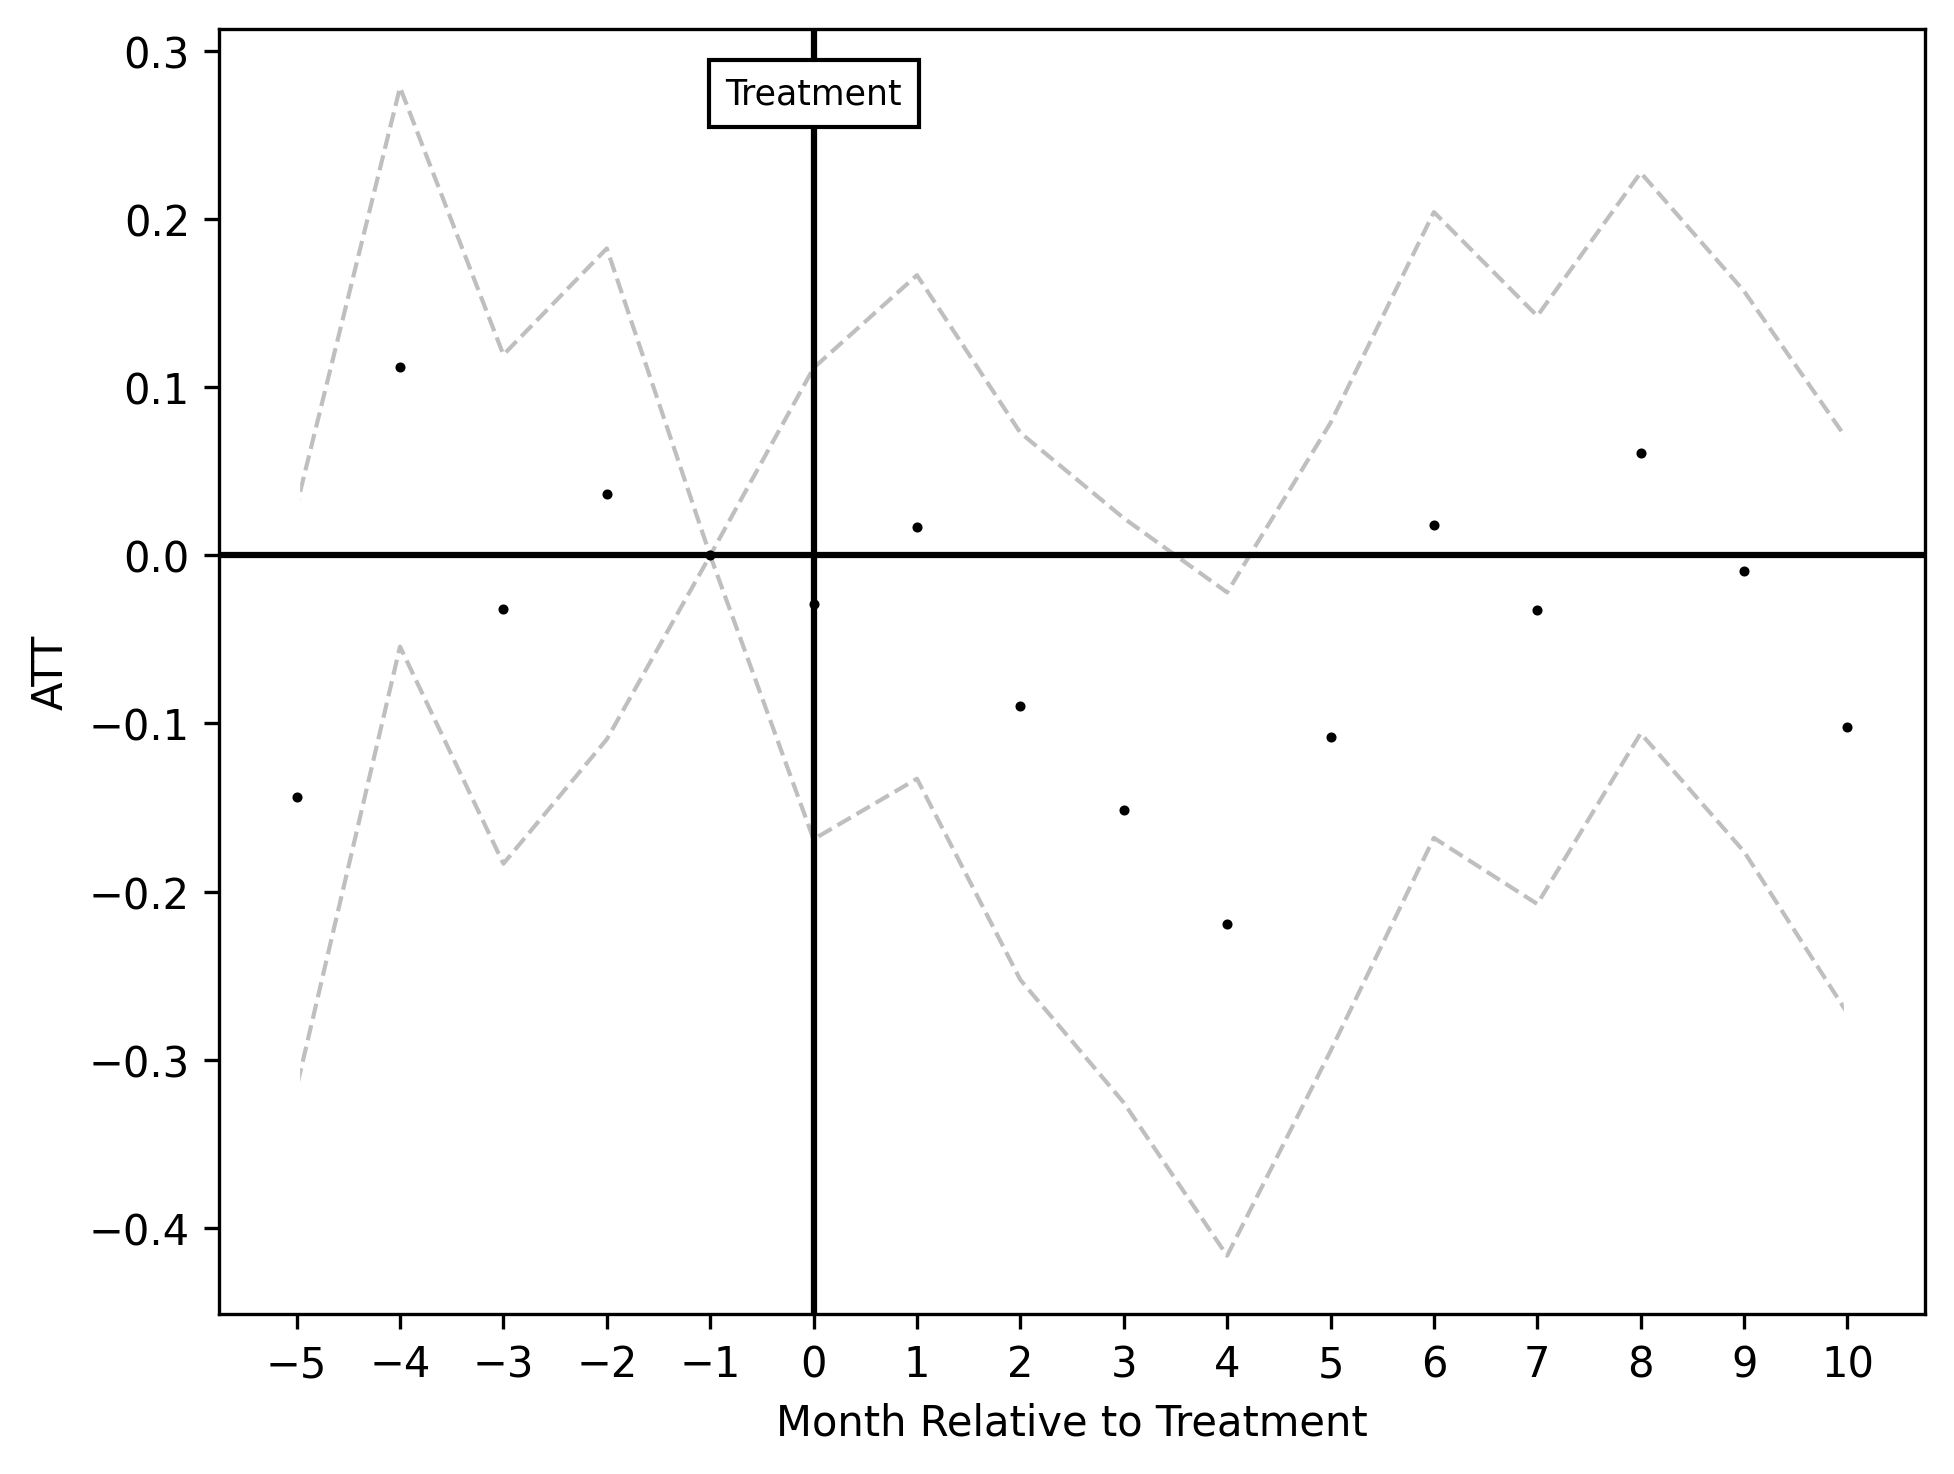

In [9]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-5, end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

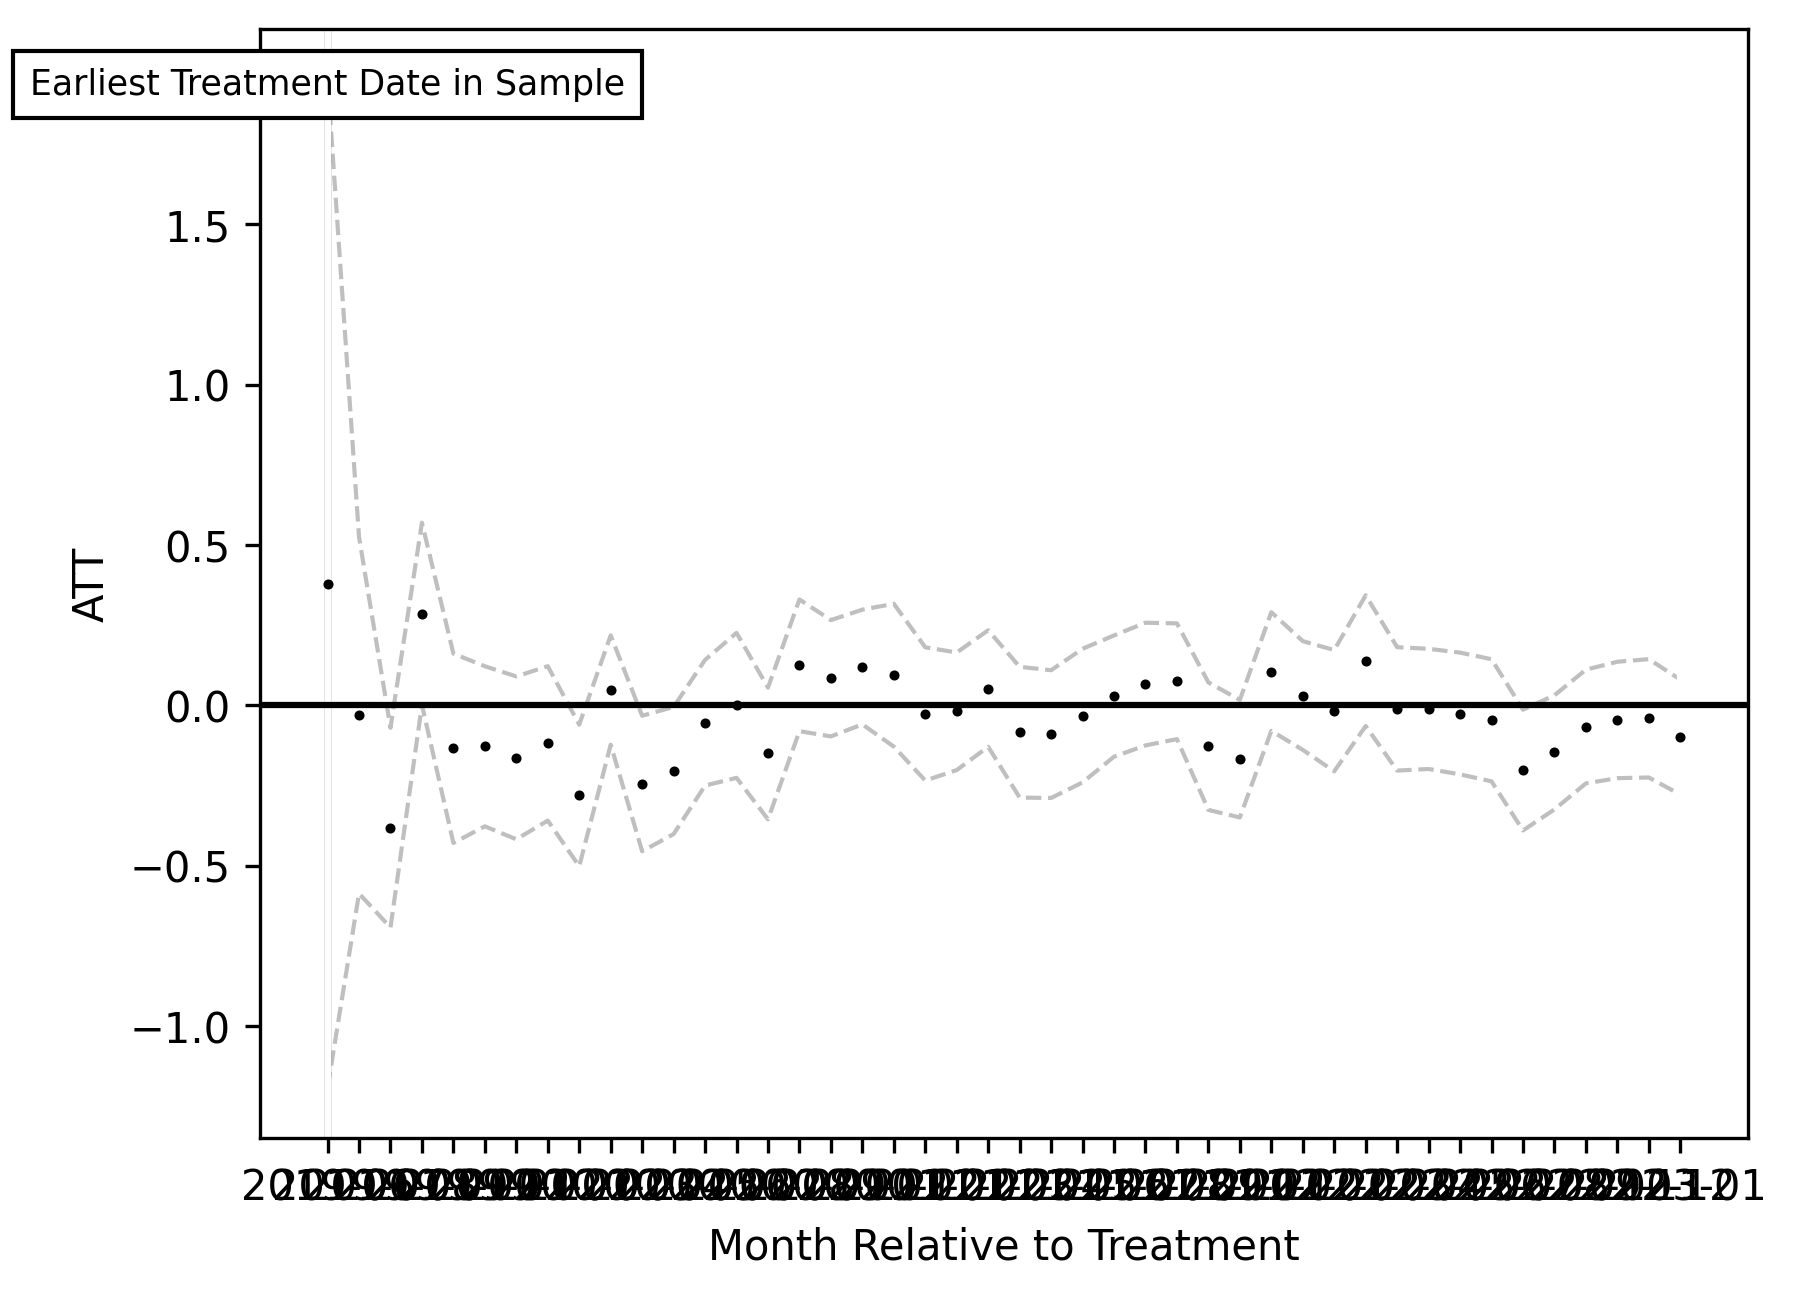

In [10]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [11]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 920/920 [00:18<00:00, 50.71it/s] 


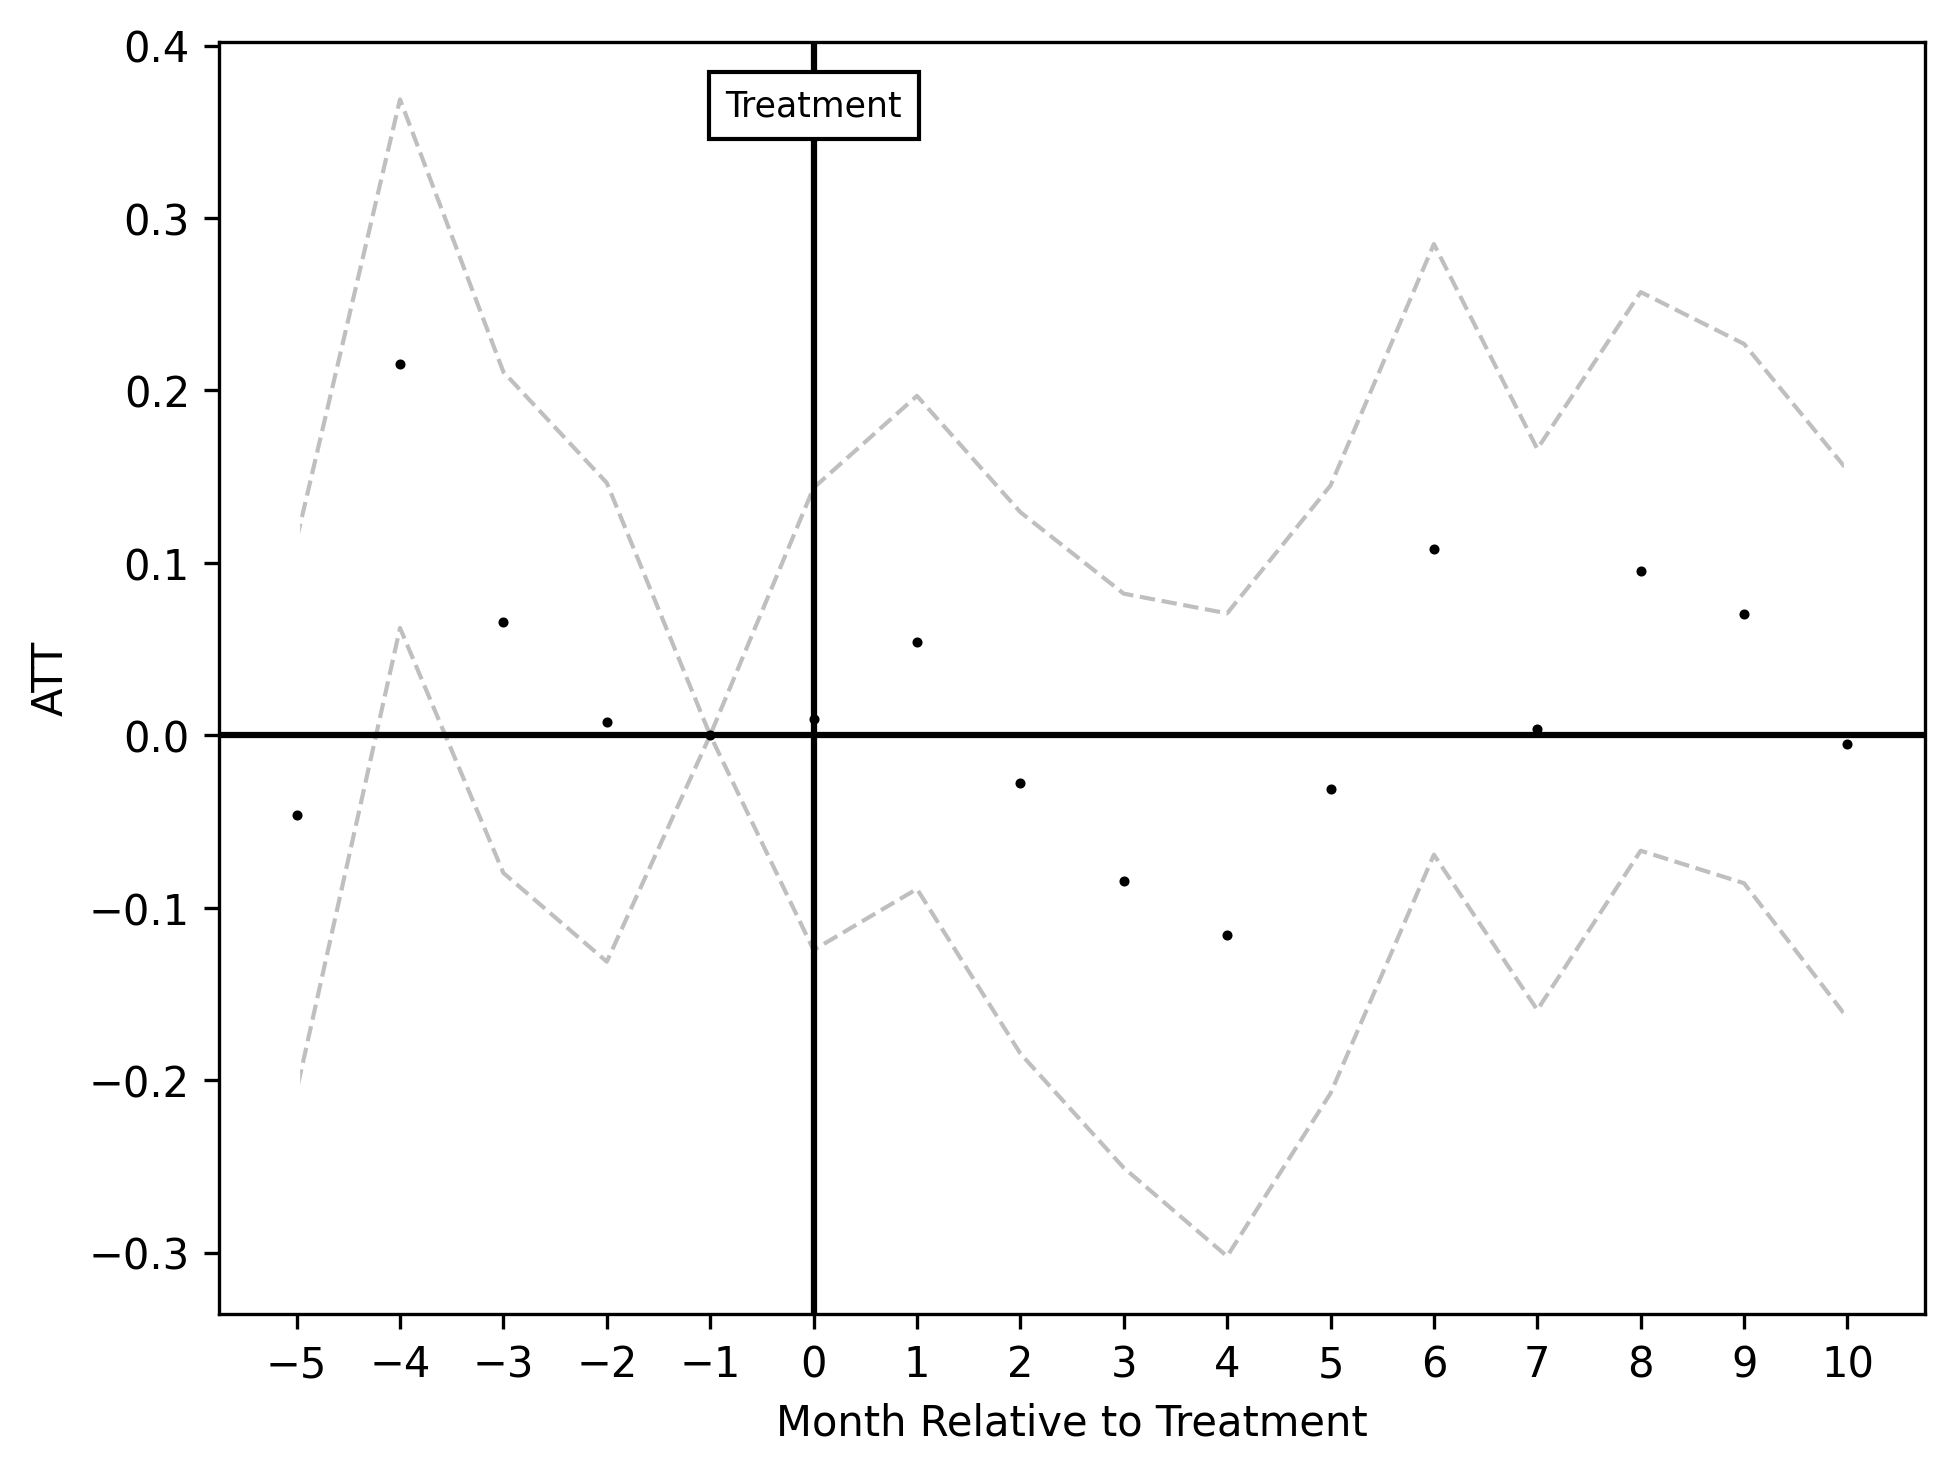

In [12]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-5,
                                 end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

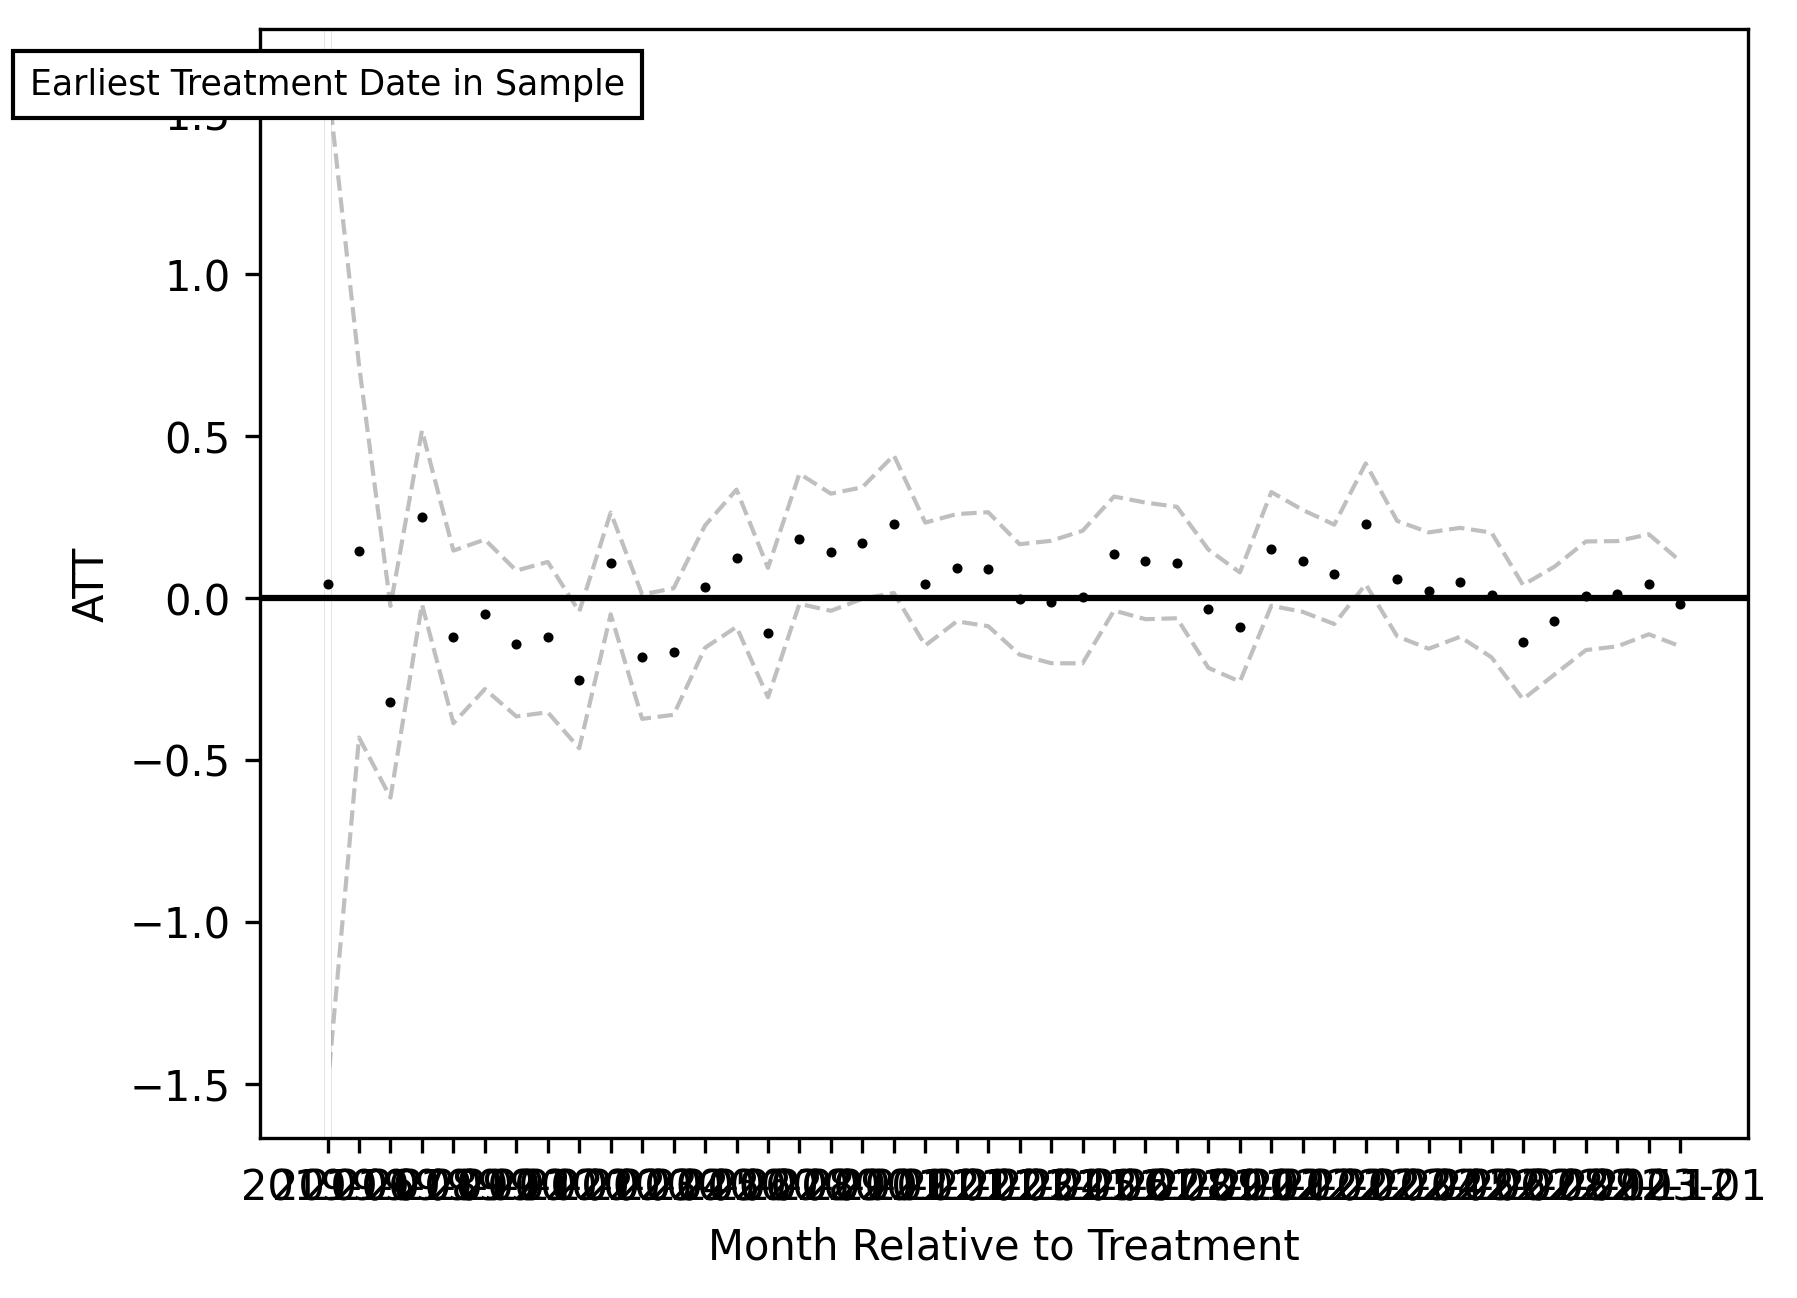

In [13]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")